# Exporing aviation accidents data

Link to kagge: https://www.kaggle.com/khsamaha/aviation-accident-database-synopses

## Dataset purpose
In some comment I've read interesting questions about this dataset:

> * Which is the type accident often to happen? Which are the features relevant?
* What is season that there are more accident?
* The amateur have a influence on accident or injury severity?
* Do they take too long to make preliminary reports?
* What do scheme have more accident?
* Where are there more accident? - deprecated
* What do aircraft have more accident? -deprecated
* How do accidents evolve in the time of aviation in the United States?

Credits:
* I took some useful functions from https://www.kaggle.com/helgejo/titanic/an-interactive-data-science-tutorial

**NOTE** this is a work in progress


In [1]:
# Python libraries
import math
import re
import datetime


# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import StandardScaler, Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 12 , 10


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Plot and data study helpers

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[ var ].min() , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
def category_values(dataframe, categories):
    for c in categories:
        print('\n', dataframe.groupby(by=c)[c].count().sort_values(ascending=False))
        print('Nulls: ', dataframe[c].isnull().sum())


## Loading data

In [3]:
df = pd.read_csv('AviationDataEnd2016UP.csv', sep=',', header=0, encoding = 'iso-8859-1')

df.sample(10)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.Flight,Air.Carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Report.Status,Publication.Date
14107,20081007X93846,Accident,DFW08CA207,2008-08-14,"Abbeville, LA",United States,29.975556,-92.083889,NaN,NaN,...,Instructional,NaN,NaN,NaN,1.0,2.0,VMC,TAKEOFF,Probable Cause,22/01/2009
61220,20001213X31653,Accident,SEA87FA135,1987-07-12,"SITKA, AK",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,VMC,MANEUVERING,Probable Cause,29/11/1988
8019,20111209X01336,Accident,CEN12CA099,2011-12-03,"Wauseon, OH",United States,41.610278,-84.127223,USE,Fulton County,...,Instructional,NaN,NaN,NaN,NaN,1.0,VMC,LANDING,Probable Cause,27/03/2012
10083,20101213X72530,Incident,CEN11IA106,2010-10-21,"Olathe, KS",United States,38.846666,-94.736666,OJC,Johnson County Exec Airport,...,Flight Test,NaN,NaN,NaN,NaN,1.0,VMC,TAKEOFF,Probable Cause,17/01/2012
23743,20030930X01623,Accident,ATL03LA144,2003-09-21,"Summerville, SC",United States,33.051111,-80.267778,DYB,DORCHESTER COUNTY,...,Personal,NaN,NaN,NaN,1.0,NaN,VMC,DESCENT,Probable Cause,28/06/2006
28832,20010430X00837,Accident,CHI01LA127,2001-04-29,"Eveleth, MN",United States,NaN,NaN,EVM,Eveleth-Virginia Municipal,...,Personal,NaN,NaN,NaN,NaN,3.0,VMC,GO-AROUND,Probable Cause,28/05/2002
49181,20001211X14446,Accident,LAX92LA158,1992-04-01,"DOUGLAS, AZ",United States,NaN,NaN,P03,COCHISE COLLEGE AIRPORT,...,Instructional,NaN,0.0,0.0,3.0,0.0,VMC,TAXI,Probable Cause,26/08/1993
40294,20001208X05118,Accident,CHI96LA082,1996-01-24,"ROMULUS, MI",United States,NaN,NaN,DTW,DETROIT METROPOLITAN,...,Executive/Corporate,NaN,0.0,0.0,0.0,8.0,IMC,LANDING,Probable Cause,09/05/1996
14837,20080508X00635,Accident,SEA08FA116B,2008-05-02,"McCall, ID",United States,44.888611,-116.101667,KMYL,McCall Municipal Airport,...,Personal,NaN,3.0,1.0,2.0,NaN,VMC,APPROACH,Probable Cause,16/04/2009
63083,20001213X34916,Accident,ATL87LA013,1986-10-31,"WINSTON-SALEM, NC",United States,NaN,NaN,INT,SMITH REYNOLDS,...,Instructional,NaN,0.0,0.0,0.0,1.0,VMC,GO-AROUND,Probable Cause,NaN


### Getting info on the fields types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79293 entries, 0 to 79292
Data columns (total 31 columns):
Event.Id                  79293 non-null object
Investigation.Type        79293 non-null object
Accident.Number           79293 non-null object
Event.Date                79293 non-null object
Location                  79215 non-null object
Country                   78786 non-null object
Latitude                  25751 non-null float64
Longitude                 25742 non-null float64
Airport.Code              44666 non-null object
Airport.Name              47439 non-null object
Injury.Severity           79293 non-null object
Aircraft.Damage           76883 non-null object
Aircraft.Category         22477 non-null object
Registration.Number       76209 non-null object
Make                      79204 non-null object
Model                     79175 non-null object
Amateur.Built             78721 non-null object
Number.of.Engines         75175 non-null float64
Engine.Type             

Let's see what kind of numeric data we have

In [5]:
df.describe()

,Latitude,Longitude,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,25751.000000,25742.000000,75175.000000,55984.000000,53742.000000,54833.000000,66949.000000
mean,37.690421,-93.781061,1.148055,0.814679,0.317703,0.502581,5.790886
std,12.148019,39.243662,0.453847,6.233700,1.372924,2.781994,29.223016
min,-78.016945,-178.676111,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.379445,-115.008542,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.184166,-94.498055,1.000000,0.000000,0.000000,0.000000,1.000000
75%,42.566528,-81.725834,1.000000,1.000000,0.000000,1.000000,2.000000
max,89.218056,177.557778,18.000000,349.000000,111.000000,380.000000,699.000000


### Getting some counts on how many different values are there for each feature

In [6]:
describe_more(df)

,Datatype,Levels,Variable
1,object,2,Investigation.Type
16,object,2,Amateur.Built
27,object,3,Weather.Condition
20,object,3,Schedule
11,object,3,Aircraft.Damage
29,object,4,Report.Status
17,float64,6,Number.of.Engines
28,object,12,Broad.Phase.of.Flight
12,object,13,Aircraft.Category
18,object,14,Engine.Type


In [7]:
# splitting date field in the components

df['Year'] = df['Event.Date'].apply(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d").year)
df['Month'] = df['Event.Date'].apply(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d").month)
df['Day'] = df['Event.Date'].apply(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d").day)

df = df[df['Year'] >= 1982]

### Looking at some categories
I try to list some unique values in the categories fields to subsequently plot some data distribution over those.

In [8]:
categories = ['Investigation.Type',
             'Aircraft.Damage',
             'Aircraft.Category',
             'Amateur.Built',
             'Number.of.Engines',
             'Engine.Type',
             'FAR.Description',
             'Schedule',
             'Purpose.of.Flight',
             'Weather.Condition',
             'Broad.Phase.of.Flight',
             'Report.Status',
             'Air.Carrier']

for c in categories:
    print(c , df[c].unique())


Investigation.Type ['Accident' 'Incident']
Aircraft.Damage ['Substantial' 'Destroyed' nan 'Minor']
Aircraft.Category ['Airplane' 'Helicopter' 'Weight-Shift' 'Glider' 'Unknown' 'Balloon'
 'Powered Parachute' 'Ultralight' 'Gyroplane' 'Gyrocraft' nan
 'Powered-Lift' 'Rocket' 'Blimp']
Amateur.Built ['Yes' 'No' nan]
Number.of.Engines [ nan   1.   2.   0.   4.   3.  18.]
Engine.Type ['Reciprocating' nan 'Turbo Prop' 'Turbo Fan' 'Turbo Shaft' 'Unknown'
 'Turbo Jet' 'Electric' 'REC, ELEC' 'None' 'TF, TJ' 'Hybrid Rocket'
 'REC, TJ, TJ' 'REC, TJ, REC, TJ' 'TJ, REC, REC, TJ']
FAR.Description ['Part 91: General Aviation' nan 'Part 135: Air Taxi & Commuter'
 'Public Aircraft' 'Part 121: Air Carrier' 'Unknown'
 'Non-U.S., Non-Commercial' 'Part 137: Agricultural' 'Non-U.S., Commercial'
 'Part 103: Ultralight' 'Part 133: Rotorcraft Ext. Load' 'Public Use'
 'Part 129: Foreign' 'Armed Forces' 'Part 437: Commercial Space Flight'
 'Part 91 Subpart K: Fractional' 'Part 125: 20+ Pax,6000+ lbs'
 'Part 91F: S

### Counting the number of different values for each category feature

In [9]:
category_values(df, categories)



 Investigation.Type
Accident    76112
Incident     3175
Name: Investigation.Type, dtype: int64
Nulls:  0

 Aircraft.Damage
Substantial    57049
Destroyed      17316
Minor           2512
Name: Aircraft.Damage, dtype: int64
Nulls:  2410

 Aircraft.Category
Airplane             19273
Helicopter            2360
Glider                 381
Balloon                175
Gyrocraft              100
Weight-Shift            66
Powered Parachute       48
Unknown                 32
Ultralight              31
Powered-Lift             5
Blimp                    3
Gyroplane                2
Rocket                   1
Name: Aircraft.Category, dtype: int64
Nulls:  56810

 Amateur.Built
No     71099
Yes     7616
Name: Amateur.Built, dtype: int64
Nulls:  572

 Number.of.Engines
1.0     63077
2.0     10057
0.0      1143
3.0       477
4.0       415
18.0        1
Name: Number.of.Engines, dtype: int64
Nulls:  4117

 Engine.Type
Reciprocating       64593
Turbo Shaft          3305
Turbo Prop           3042
Turbo 

## Filling Null values

The data is full of Null values. I'll try to fix the nulls copying data from the rest of the dataset when possible. For the rest I'll put 'unknown' strings.

In [10]:
# null damages can't be defined
df[df['Aircraft.Damage'].isnull()]
df['Aircraft.Damage'].fillna('Unknown', inplace=True)

# Fixing phase of flight nulls
df['Broad.Phase.of.Flight'].fillna('UNKNOWN', inplace=True)

# Fixing weather conditions
df['Weather.Condition'].fillna('UNK', inplace=True)

# null categories can't be defined
df['Aircraft.Category'].fillna('Unknown', inplace=True)

# can't define purpose of flight
df['Purpose.of.Flight'].fillna('Unknown', inplace=True)

# don't know ho to set missing schedules 
df['Schedule'].fillna('UNK', inplace=True)

# don't know ho to set missing FAR.Description
df['FAR.Description'].fillna('Unknown', inplace=True)

# don't know ho to set missing Aircraft.Damage
df['Aircraft.Damage'].fillna('Unknown', inplace=True)

# don't know ho to set missing Air Carriers
df['Air.Carrier'].fillna('Unknown', inplace=True)

# don't know ho to set missing Makers
df['Make'].fillna('UNKNOWN', inplace=True)

# don't know ho to set missing Models
df['Model'].fillna('Unknown', inplace=True)

# don't know ho to set missing airport names
df['Airport.Name'].fillna('Unknown', inplace=True)

# don't know ho to set missing Models
df['Airport.Code'].fillna('Unknown', inplace=True)

# don't know ho to set missing Locations
df['Location'].fillna('Unknown', inplace=True)

#### Amateur producers
Instead of putting an 'unknown' value in the Amateur.Built field, I've collected all the producers and all the amateurs brands/names from the rest of the dataset and filled the null cells searching in the resulting two lists. For the remaining marks that are not present anywhere in the dataset I chose to set them as amateurs.

In [11]:
# Extracting producers and amateurs
producers = [x for x in df['Make'][df['Amateur.Built']== 'No'].unique() ]
amateurs  = [x for x in df['Make'][df['Amateur.Built']== 'Yes'].unique() ]

# -----------------------------------------------
# Function that fixes the null in amateur.built
def fix_amateur_built(ab, m):
    if type(ab) == str:
        return ab
    else:
        if m in producers:
            return 'No'
        else:
            return 'Yes'
# Fix for Amateur.Built field      
am_built = df.apply(lambda x: fix_amateur_built(x['Amateur.Built'], x['Make']), axis=1)
df = df.assign(AmateurBuilt = am_built, index=df.index)



#### Number of engines
For the balloons I'll set this value to 0.
For the remaining, I'll make some assumptions and aproximations based on the rest of the values.

In [12]:
# Function that fixes the null in number.of.engines
def fix_number_of_engines(noe, m):
    if noe >= 0:
        return noe
    else:
        # Setting number of engines at the mean number of engines for the producer
        r = np.round(df['Number.of.Engines'][df['Make']==m].mean())
        return r

# Setting 0 engines for balloons
df['Number.of.Engines'][df['Number.of.Engines'].isnull() & (df['Make'].str.contains('balloon', case=False))] = 0.0
# Correcting number of engines
num_engines = df.apply(lambda x: fix_number_of_engines(x['Number.of.Engines'], x['Make']), axis=1)
df = df.assign(NumberofEngines = num_engines, index=df.index)
# Still some null after number of engines correction
df['NumberofEngines'].fillna(1, inplace=True)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Engine types
Taking engine types from the rest of the data

In [13]:
# Function that fixes the engine types
def fix_engine_type(et, model):
    if type(et) == str:
        return et
    else:
        # Setting engine type at the mode of engines for the model
        e = (df['Engine.Type'][df['Model']==model].mode())
        return  e[0] if e.count() > 0 else 'Unknown'
# Fix for Engine.Type field      
en_type = df.apply(lambda x: fix_engine_type(x['Engine.Type'], x['Model']), axis=1)
df = df.assign(EngineType = en_type, index=df.index)


### Aircraft Category
Taking Aircraft Categories from the rest of the data

In [14]:
# Function that fixes the Aircraft.Category
def fix_aircraft_category(cat, model):
    if type(cat) == str:
        return cat
    else:
        # Setting aircraft category at the mode of caterogories for the model
        e = (df['Aircraft.Category'][df['Model']==model].mode())
        return  e[0] if e.count() > 0 else 'Unknown'
# Fix for Aircraft.Category field      
aircraft_cat = df.apply(lambda x: fix_aircraft_category(x['Aircraft.Category'], x['Model']), axis=1)
df = df.assign(AircraftCategory = aircraft_cat, index=df.index)


### Country
It seems that null countries are all outside U.S.

In [15]:
# null countries are outside US
df[df['Country'].isnull()]
df['Country'].fillna('Foreign', inplace=True)

### Injuries
I add a colunm that represents the total number of injuries in the accidents.

In [16]:
df['Injuries'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries']

### Checking if all nulls have been fixed

In [17]:
#category_values(df, ['AircraftCategory', 'Country', 'EngineType', 'NumberofEngines', 'AmateurBuilt'])
#df['EngineType'].sample(100)

#df.groupby(by=['Location']).count()
df.isnull().sum()


Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                      0
Country                       0
Latitude                  53537
Longitude                 53546
Airport.Code                  0
Airport.Name                  0
Injury.Severity               0
Aircraft.Damage               0
Aircraft.Category             0
Registration.Number        3084
Make                          0
Model                         0
Amateur.Built               572
Number.of.Engines          3985
Engine.Type                3373
FAR.Description               0
Schedule                      0
Purpose.of.Flight             0
Air.Carrier                   0
Total.Fatal.Injuries      23309
Total.Serious.Injuries    25550
Total.Minor.Injuries      24458
Total.Uninjured           12342
Weather.Condition             0
Broad.Phase.of.Flight         0
Report.Status                 0
Publication.Date          13473
Year    

### Dropping columns that I will not use 
There are some columns that I think are not so useful and others that have been replaced by "sanitized" ones.

In [18]:
df = df.drop(['Number.of.Engines', 'Aircraft.Category', 'Engine.Type', 'Amateur.Built', 'index'], axis='columns')
df = df.drop(['Publication.Date'], axis='columns')

## Now some visualization
A better way to understand what's inside the data is to put some features in charts.

TODO: comment

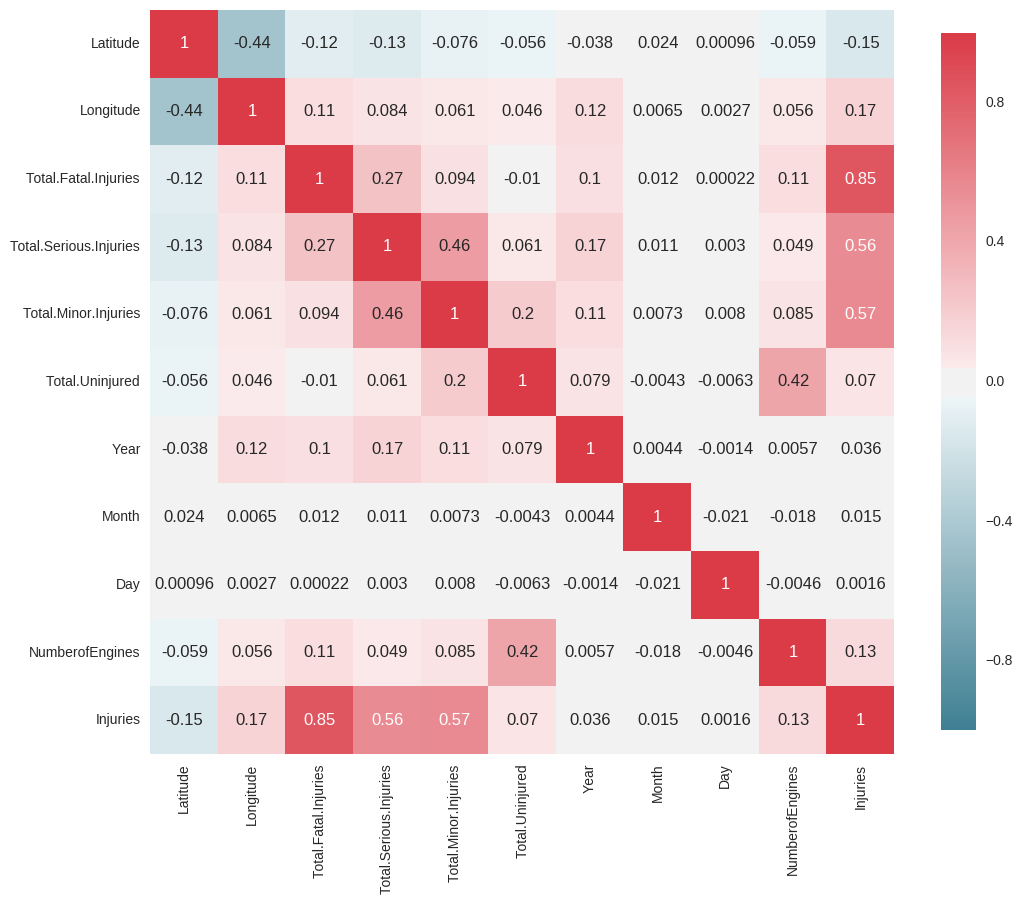

In [19]:
plot_correlation_map(df)

An observation: the number of uninjuried seems to be very related to the number of engines. Could it mean that a second engine helps in some kind of accident?

### Time series charts
Let's see on the timeline some events.


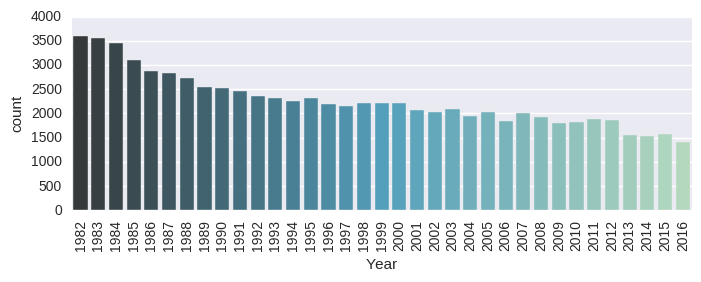

In [20]:
# For the time series charts I start sorting data
df = df.sort_values(by=['Year', 'Month', 'Day'], ascending=True)

years = np.arange(1982, 2017)

sns.set(style="darkgrid")

plt.subplot(211)

g = sns.countplot(x="Year", data=df, palette="GnBu_d", order=years)
g.set_xticklabels(labels=years)
a = plt.setp(g.get_xticklabels(), rotation=90)


## Linear regression on number of incidents

Given the histogram before, it should be easy to make a linear regression to predict next years' incidents.

Score for degree 0: 0.868 - prediction for 2017 is 1366
Score for degree 1: 0.926 - prediction for 2017 is 1685
Score for degree 2: 0.982 - prediction for 2017 is 1283


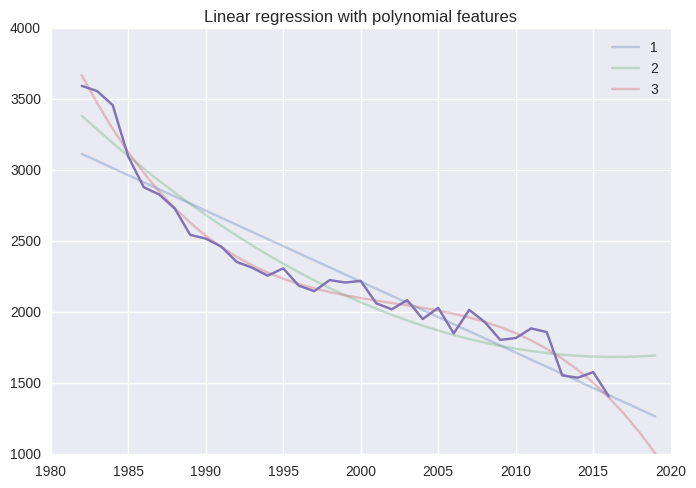

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


events_per_year = df.groupby(by='Year').count()['Event.Id']
events_per_year.drop(2017, axis=0, inplace=True)

X = [ [y] for y in events_per_year.index.values]
y = [ [e] for e in events_per_year.as_matrix()]


degrees = [1,2,3]
lr_pred_X = [[y] for y in range(1982, 2020)]
for i in range(len(degrees)):
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X, y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X, y,
                             scoring="neg_mean_squared_error", cv=10)
    lr_pred=pipeline.predict(lr_pred_X)
    plt.plot(lr_pred_X, lr_pred, alpha=.3)
    
    print("Score for degree %d: %.3f - prediction for 2017 is %d" % (i, pipeline.score(X, y), lr_pred[35]))

plt.plot(X, y)
plt.title("Linear regression with polynomial features")
plt.legend(labels=degrees)

plt.show()


## Conclusions

So far, I only wanted to work on the ways I can clean the data and on trying a linear regression on a dataset with only one feature.

I'll try to understand better the dataset contents and to imagine some other interesting visualizations and predictions.